In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
import cell_tree2d
import xmitgcm
import xgcm
import numpy as np

In [32]:
#NB This code only works with SQUARE TILES (and I need to test this some more)

llc90_extra_metadata = xmitgcm.utils.get_extra_metadata(domain='llc', nx=90)
grid = xmitgcm.utils.get_grid_from_input('/swot/SUM01/spencer/ECCO_diags/tile<NFACET>.mitgrid',
                                         geometry='llc',
                                         extra_metadata=llc90_extra_metadata)

#grid = xmitgcm.utils.get_grid_from_input('/swot/SUM01/spencer/llc_270/tile<NFACET>.mitgrid',
#                                         geometry='llc',
#                                         extra_metadata=llc90_extra_metadata)

#grid = xmitgcm.utils.get_grid_from_input('/swot/SUM01/spencer/llc_1080/tile<NFACET>.mitgrid',
#                                         geometry='llc',
#                                         extra_metadata=llc90_extra_metadata)

#1080 30x30
#blankList=[1,2,3]
#totaltiles=1869
#tilex=90
#tiley=90
#captile=0

#270 30x30
#blankList=[1,2,3]
#totaltiles=1050
#tilex=30
#tiley=30
#captile=523

#30x30
blankList=[1,2,3,5,6,28,29,30,31,32,33,49,50,52,53,72,81,90,99,108,117]
totaltiles=96
tilex=30
tiley=30
captile=43

#45x45
#blankList=[2,13,14,23]
#totaltiles=48
#tilex=45
#tiley=45
#captile=0

#45x30
#blankList=[1,2,19,20,21,22]
#totaltiles=72
#tilex=45
#tiley=30
#captile=0

#15x30
#blankList=[1,2,3,4,5,6,9,10,11,12,55,56,57,58,59,60,61,62,63,64,65,66,
#            97,98,99,100,103,104,105,106,143,144,
#            161,162,179,180,197,198,215,216,233,234]
#totaltiles=192
#tilex=15
#tiley=30
#captile=0
#note that the blank list is given starting at 1. We will not alter this, so that people
#can just copy the input

In [33]:
from dask.base import tokenize
import dask.array as dsa
from functools import reduce
import os
import xarray as xr


def get_xg_yg_from_input(gridfile, nx=None, ny=None, geometry='llc',
                        dtype=np.dtype('d'), endian='>', use_dask=False,
                        extra_metadata=None, tilex=30, tiley=30, blankList=None):
    """ 
    Read grid variables from grid input files, and tiles them according to 
    tilesizes input by the user, skipping blank tiles.
    This function only reads xg and yg, and outputs all the values stored in the
    input grid file (including the rightmost and uppermost xg and yg values). 
    It is useful for findingwhere a lat/lon point is on the llc grid. 
    
    PARAMETERS
    ----------
    gridfile : str
        gridfile must contain <NFACET> as wildcard (e.g. tile<NFACET>.mitgrid)
    nx : int
        size of the face in the x direction
    ny : int
        size of the face in the y direction
    geometry : str
        domain geometry can be llc, cs or carthesian not supported yet
    dtype : np.dtype
        numeric precision (single/double) of input data
    endian : string
        endianness of input data
    use_dask : bool
        use dask or not
    extra_metadata : dict
        dictionary of extra metadata, needed for llc configurations
    tilex : int
        size of tile in the x direction
    tiley : int
        size of tile in the y direction
    blankList : arraylike
        List of blank tiles (indexing starts at 1 so that you can copy 
        directly from data.exch2)
    RETURNS
    ------- 
    grid : xarray.Dataset
        all grid variables
    """

    file_metadata = {}
    # grid variables are stored in this order
    file_metadata['fldList'] = ['XC', 'YC', 'DXF', 'DYF', 'RAC',
                                'XG', 'YG', 'DXV', 'DYU', 'RAZ',
                                'DXC', 'DYC', 'RAW', 'RAS', 'DXG', 'DYG']

    file_metadata['vars'] = file_metadata['fldList']
    dims_vars_list = []
    for var in file_metadata['fldList']:
        dims_vars_list.append(('ny', 'nx'))
    file_metadata['dims_vars'] = dims_vars_list

    # no vertical levels or time records
    file_metadata['nz'] = 1
    file_metadata['nt'] = 1

# for curvilinear non-facet grids (TO DO)
#    if nx is not None:
#        file_metadata['nx'] = nx
#    if ny is not None:
#        file_metadata['ny'] = ny
    if extra_metadata is not None:
        file_metadata.update(extra_metadata)

    # numeric representation
    file_metadata['endian'] = endian
    file_metadata['dtype'] = dtype

    if geometry == 'llc':
        nfacets = 5
        try:
            nfaces = len(file_metadata['face_facets'])
        except:
            raise ValueError('metadata must contain face_facets')
    if geometry == 'cs':  # pragma: no cover
        raise NotImplementedError("'cs' geometry is not supported yet")

    # create placeholders for data
    gridfields = {}
    for field in ['XG', 'YG']:#
        gridfields.update({field: None})

    if geometry == 'llc':
        tileno=0
        dummy=0
        for kfacet in range(nfacets):
            # we need to adapt the metadata to the grid file
            grid_metadata = file_metadata.copy()

            fname = gridfile.replace('<NFACET>', str(kfacet+1).zfill(3))
            grid_metadata['filename'] = fname

            if file_metadata['facet_orders'][kfacet] == 'C':
                nxgrid = file_metadata['nx'] + 1
                nygrid = file_metadata['ny_facets'][kfacet] + 1
            elif file_metadata['facet_orders'][kfacet] == 'F':
                nxgrid = file_metadata['ny_facets'][kfacet] + 1
                nygrid = file_metadata['nx'] + 1

            grid_metadata.update({'nx': nxgrid, 'ny': nygrid,
                                  'has_faces': False})

            raw = read_all_variables(grid_metadata['vars'], grid_metadata,
                                     use_dask=use_dask)

            rawfields = {}
            for kfield in np.arange(len(file_metadata['fldList'])):

                rawfields.update(
                    {file_metadata['fldList'][kfield]: raw[kfield]})
                
            tiles_on_facet=(nxgrid-1)*(nygrid-1)//tilex//tiley
            tile_in_x=(nxgrid-1)//tilex
            tile_in_y=(nygrid-1)//tiley

            for field in ['XG', 'YG']:
                if field =='XG':
                    save_tile=tileno
                else:
                    tileno=save_tile
                    if kfacet == 0:
                        dummy=0
                # symetrize
                tmp = rawfields[field][:, :, :, :].squeeze()
                # transpose
                if grid_metadata['facet_orders'][kfacet] == 'F':
                    tmp = tmp.transpose()

                for tileon in range(0,tiles_on_facet):
                    tileno=tileno+1
                    if tileno not in blankList:
                        offsety=(tileon//tile_in_x)
                        offsetx=(tileon-offsety*tile_in_x)
                        #transpose facet if needed
                        tmpt=tmp
                        if file_metadata['facet_orders'][kfacet] == 'F':
                            tmpt=tmp.transpose()
                        # extract the data
                        dataface = tmpt[offsety*tiley:(offsety+1)*tiley+1,offsetx*tilex:(offsetx+1)*tilex+1]
                        # assign values
                        dataface = dsa.stack([dataface], axis=0)
                        if dummy == 0:
                            gridfields[field] = dataface
                            dummy=1
                        else:
                            gridfields[field] = dsa.concatenate(
                                [gridfields[field], dataface], axis=0)

    elif geometry == 'cs':  # pragma: no cover
        raise NotImplementedError("'cs' geometry is not supported yet")
        pass

    # create the dataset
    if geometry in ['llc', 'cs']:
        ntile=gridfields['XG'].shape[0]
        grid = xr.Dataset({'XG':  (['tile', 'j_g', 'i_g'], gridfields['XG']),
                           'YG':  (['tile', 'j_g', 'i_g'], gridfields['YG']),
                           },
                          coords={'i_g': (['i_g'],
                                          np.arange(tilex+1)),
                                  'j_g': (['j_g'],
                                          np.arange(tiley+1)),
                                  'tile': (['tile'], np.arange(ntile))
                                  }
                          )
    else:  # pragma: no cover
        grid = xr.Dataset({'XG':  (['j_g', 'i_g'], gridfields['XG']),
                           'YG':  (['j_g', 'i_g'], gridfields['YG']),
                           },
                          coords={'i_g': (['i_g'],
                                          np.arange(tilex+1)),
                                  'j_g': (['j_g'],
                                          np.arange(tiley+1))
                                  }
                          )

    return grid

def read_all_variables(variable_list, file_metadata, use_mmap=False,
                       use_dask=False, chunks="3D"):
    """
    Return a dictionary of dask arrays for variables in a MDS file
    PARAMETERS
    ----------
    variable_list : list
        list of MITgcm variables, from fldList in .meta
    file_metadata : dict
        internal metadata for binary file
    use_mmap : bool, optional
        Whether to read the data using a numpy.memmap
    chunks : str, optional
        Whether to read 2D (default) or 3D chunks
        2D chunks are reading (x,y) levels and 3D chunks
        are reading the a (x,y,z) field
    RETURNS
    -------
    out : list
        list of data arrays (dask.array, numpy.ndarray or memmap)
        corresponding to variables from given list in the file
        described by file_metadata
    """

    out = []
    for variable in variable_list:
        if chunks == "2D":
            out.append(read_2D_chunks(variable, file_metadata,
                                      use_mmap=use_mmap, use_dask=use_dask))
        elif chunks == "3D":
            out.append(read_3D_chunks(variable, file_metadata,
                                      use_mmap=use_mmap, use_dask=use_dask))

    return out

def read_3D_chunks(variable, file_metadata, use_mmap=False, use_dask=False):
    """
    Return dask array for variable, from the file described by file_metadata,
    reading 3D chunks. Not suitable for llc data.
    Parameters
    ----------
    variable : string
               name of the variable to read
    file_metadata : dict
               internal file_metadata for binary file
    use_mmap : bool, optional
               Whether to read the data using a numpy.memmap
    use_dask : bool, optional
               collect the data lazily or eagerly
    Returns
    -------
    dask array for variable, with 3d (nz, ny, nx) chunks
    or numpy.ndarray or memmap, depending on input args
    """

    def load_chunk(rec):
        return _read_xyz_chunk(variable, file_metadata,
                               rec=rec,
                               use_mmap=use_mmap)[None]

    chunks = (1, file_metadata['nz'], file_metadata['ny'], file_metadata['nx'])
    shape = (file_metadata['nt'], file_metadata['nz'],
             file_metadata['ny'], file_metadata['nx'])
    name = 'mds-' + tokenize(file_metadata, variable)

    dsk = {(name, rec, 0, 0, 0): (load_chunk, rec)
           for rec in range(file_metadata['nt'])}

    data = dsa.Array(dsk, name, chunks,
                     dtype=file_metadata['dtype'], shape=shape)

    if not use_dask:
        data = data.compute()

    return data

def _read_xyz_chunk(variable, file_metadata, rec=0, use_mmap=False):
    """
    Read a 3d chunk (x,y,z) of variable from file described in
    file_metadata.
    Parameters
    ----------
    variable : string
               name of the variable to read
    file_metadata : dict
               file_metadata for binary file
    rec      : integer, optional
               time record to read (default=0)
    use_mmap : bool, optional
               Whether to read the data using a numpy.memmap
    Returns
    -------
    numpy array or memmap
    """

    if file_metadata['has_faces'] and ((file_metadata['nx'] > 1) or
                                       (file_metadata['ny'] > 1)):
        raise ValueError("_read_xyz_chunk cannot be called with llc type grid")

    # size of the data element
    nbytes = file_metadata['dtype'].itemsize
    # byte order
    file_metadata['datatype'] = file_metadata['dtype'].newbyteorder(
        file_metadata['endian'])
    # find index of variable
    idx_var = file_metadata['vars'].index(variable)

    # 1. compute offset_variable, init to zero
    offset_vars = 0
    # loop on variables before the one to read
    for jvar in np.arange(idx_var):
        # inspect its dimensions
        dims = file_metadata['dims_vars'][jvar]
        # compute the byte size of this variable
        nbytes_thisvar = 1*nbytes
        for dim in dims:
            nbytes_thisvar = nbytes_thisvar*file_metadata[dim]
        # update offset from previous variables
        offset_vars = offset_vars+nbytes_thisvar

    # 2. get dimensions of desired variable
    dims = file_metadata['dims_vars'][idx_var]
    # inquire for values of dimensions, else return 1
    nt, nz, ny, nx = [file_metadata.get(dimname, 1)
                      for dimname in ('nt', 'nz', 'ny', 'nx')]

    # 3. compute offset from previous records of current variable
    if (rec > nt-1):
        raise ValueError("time record %g greater than number of records %g" %
                         (rec, nt))
    else:
        offset_timerecords = rec * nz * ny * nx * nbytes

    # 4. compute the offset of the previous variables, records and levels
    offset = offset_vars + offset_timerecords
    shape = (nz, ny, nx,)

    # check if we do a partial read of the file
    if (nt > 1) or (len(file_metadata['vars']) > 1):
        partial_read = True
    else:
        partial_read = False

    # define the order (row/column major)
    # in conventional grids, it's in C
    order = 'C'

    # 5. Do the actual read
    data = read_raw_data(file_metadata['filename'],
                         file_metadata['datatype'],
                         shape, use_mmap=use_mmap, offset=offset,
                         order=order, partial_read=partial_read)

    return data

def read_raw_data(datafile, dtype, shape, use_mmap=False, offset=0,
                  order='C', partial_read=False):
    """Read a raw binary file and shape it.
    PARAMETERS
    ----------
    datafile : str
        Path to a .data file
    dtype : numpy.dtype
        Data type of the data
    shape : tuple
        Shape of the data
    use_memmap : bool, optional
        Whether to read the data using a numpy.memmap
    offset : int, optional
        Offset (in bytes) to apply on read
    order : str, optional
        Row/Column Major = 'C' or 'F'
    partial_read : bool, optional
        If reading part of the file
    RETURNS
    -------
    data : numpy.ndarray
        The data (or a memmap to it)
    """

    number_of_values = reduce(lambda x, y: x * y, shape)
    expected_number_of_bytes = number_of_values * dtype.itemsize
    actual_number_of_bytes = os.path.getsize(datafile)
    if not partial_read:
        # first check that partial_read and offset are used together
        if offset != 0:
            raise ValueError(
                'When partial_read==False, offset will not be read')
        # second check to be sure there is the right number of bytes in file
        if expected_number_of_bytes != actual_number_of_bytes:
            raise IOError('File `%s` does not have the correct size '
                          '(expected %g, found %g)' %
                          (datafile,
                           expected_number_of_bytes,
                           actual_number_of_bytes))
    else:
        pass

    if offset < actual_number_of_bytes:
        pass
    else:
        raise ValueError('bytes offset %g is greater than file size %g' %
                         (offset, actual_number_of_bytes))

    with open(datafile, 'rb') as f:
        if use_mmap:
            data = np.memmap(f, dtype=dtype, mode='r', offset=offset,
                             shape=tuple(shape), order=order)
        else:
            f.seek(offset)
            data = np.fromfile(f, dtype=dtype, count=number_of_values)
            data = data.reshape(shape, order=order)
    data.shape = shape
    return data

def _pad_array(data, file_metadata, face=0):
    """
    Return a padded array. If input data is a numpy.memmap and no padding
    is necessary, the function preserves its type. Otherwise, the concatenate
    forces it to load into memory.
    Parameters
    ----------
    data          : numpy array or memmap
                    input data
    file_metadata : dict
                    metadata for file
    face          : int, optional
                    llc face if applicable
    Returns
    -------
    numpy.array or numpy.memmap
    """

    # Pad data before in y direction
    if 'pad_before_y' in file_metadata:
        if file_metadata['has_faces']:
            facet_origin = file_metadata['face_facets'][face]
            nypad_before = file_metadata['pad_before_y'][facet_origin]
        else:
            nypad_before = file_metadata['pad_before_y']

        pad_before = np.zeros((nypad_before, file_metadata['nx']))
        data_padded_before = np.concatenate(
            (pad_before, data), axis=0)
    else:
        data_padded_before = data

    # Pad data after in y direction
    if 'pad_after_y' in file_metadata:
        if file_metadata['has_faces']:
            facet_origin = file_metadata['face_facets'][face]
            nypad_after = file_metadata['pad_after_y'][facet_origin]
        else:
            nypad_after = file_metadata['pad_after_y']

        pad_after = np.zeros((nypad_after, file_metadata['nx']))
        data_padded_after = np.concatenate(
            (data_padded_before, pad_after), axis=0)
    else:
        data_padded_after = data_padded_before

    return data_padded_after

In [34]:
grid= get_xg_yg_from_input('/swot/SUM01/spencer/ECCO_diags/tile<NFACET>.mitgrid',
                                         geometry='llc',tilex=tilex, tiley=tiley,
                                         extra_metadata=llc90_extra_metadata,blankList=blankList)

In [35]:
grid

<xarray.Dataset>
Dimensions:  (i_g: 31, j_g: 31, tile: 96)
Coordinates:
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 ... 21 22 23 24 25 26 27 28 29 30
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 ... 21 22 23 24 25 26 27 28 29 30
  * tile     (tile) int64 0 1 2 3 4 5 6 7 8 9 ... 86 87 88 89 90 91 92 93 94 95
Data variables:
    XG       (tile, j_g, i_g) float64 dask.array<chunksize=(1, 31, 31), meta=np.ndarray>
    YG       (tile, j_g, i_g) float64 dask.array<chunksize=(1, 31, 31), meta=np.ndarray>

In [8]:
#what tile
def tile_tree(grid,captile,totaltiles):
    nodes3=np.stack((grid.XG.isel(i_g=[0,-1],j_g=[0,-1]).values.ravel(),
                 grid.YG.isel(i_g=[0,-1],j_g=[0,-1]).values.ravel()),1)
    if (captile>1):
        #insert additional nodes after cap node to deal with cap

        #52,142
        nodes3=np.insert(nodes3, captile*4+2, [nodes3[captile*4][0], 90], axis=0)#the 90 here is 90 degrees
        nodes3=np.insert(nodes3, captile*4+3, [nodes3[captile*4+1][0], 90], axis=0)

        #52,-38
        nodes3=np.insert(nodes3, captile*4+4, nodes3[captile*4], axis=0)#skip one and use the one in place
        nodes3=np.insert(nodes3, captile*4+6, [nodes3[captile*4][0], 90], axis=0)
        nodes3=np.insert(nodes3, captile*4+7, [nodes3[captile*4+5][0], 90], axis=0)

        #-38,-128
        nodes3=np.insert(nodes3, captile*4+8, nodes3[captile*4+5], axis=0)#skip one and use the one in place
        nodes3=np.insert(nodes3, captile*4+10, [nodes3[captile*4+5][0], 90], axis=0)
        nodes3=np.insert(nodes3, captile*4+11, [nodes3[captile*4+9][0], 90], axis=0)

        #-128,142 
        nodes3=np.insert(nodes3, captile*4+12, nodes3[captile*4+9], axis=0)#skip one and use the one in place
        nodes3=np.insert(nodes3, captile*4+13, nodes3[captile*4+1], axis=0)
        nodes3=np.insert(nodes3, captile*4+14, [nodes3[captile*4+9][0], 90], axis=0)
        nodes3=np.insert(nodes3, captile*4+15, [nodes3[captile*4+1][0], 90], axis=0)
    
        col1=np.arange(0,totaltiles*4+12,4)
    else:
        col1=np.arange(0,totaltiles*4,4)
    col2=col1+1
    col3=col1+3
    col4=col1+2
    
    faces3 = np.stack((col1,col2,col3,col4),1)
    faces = np.array(faces3, dtype=np.intc)
    nodes = np.array(nodes3, dtype=np.float64)
    #check if on dateline
    griddiff=np.diff(nodes[faces][:,:,0])
    r,c = np.where(np.abs(griddiff)>= 180)
    xnodes=nodes[faces][r,:,0]
    xnodes[xnodes<0]=xnodes[xnodes<0]+360
    nodes[faces[r,:],0]=xnodes
    tiletree = cell_tree2d.CellTree(nodes, faces,cells_per_leaf=1)
    return tiletree

def get_tile(tree,point,captile):
    result = tree.locate(point)
    #search for point: if point is not in domain, add 360 in x-dir and try again
    point2=point.copy()
    if result==-1:
        point2[0]=point2[0]+360
        result = tree.locate(point2)
    
    if (captile>1):
        #interpret result: cap splits one tile into four
        if (result>captile) & (result<captile+4):
            result=captile
        elif result>captile+3:
            result=result-3
    return result, point2

def within_tile_tree(grid,tile,tilex,tiley):
    nodes3=np.stack((grid.XG[tile,:,:].values.ravel(),grid.YG[tile,:,:].values.ravel()),1)
    col_base=np.arange(0,(tilex+1)*tiley)
    col1=np.asarray([item for item in col_base if(item+1) % (tilex+1)>0])[:-1]
    col2=col1+1
    col3=col1+tilex+2
    col4=col1+tilex+1
    faces3 = np.stack((col1,col2,col3,col4),1)
    nodes = np.array(nodes3, dtype=np.float64)
    faces = np.array(faces3, dtype=np.intc)
    griddiff=np.diff(nodes[faces][:,:,0])
    r,c = np.where(np.abs(griddiff)>= 180)
    nodes2=nodes.copy()
    if r.shape[0]>1:
        xnodes=nodes[faces][:,:,0]
        xnodes[xnodes<0]=xnodes[xnodes<0]+360
        nodes2[faces[:,:],0]=xnodes
    #xnodes=nodes[faces][r,:,0]
    #xnodes[xnodes<0]=xnodes[xnodes<0]+360
    #nodes[faces[r,:],0]=xnodes
    tree = cell_tree2d.CellTree(nodes2, faces)
    return tree

In [9]:
from math import isclose
filename='/swot/SUM01/spencer/llc_floats/pickup_flt.0000000001'
#captile=[30,33]
tree=tile_tree(grid,captile,totaltiles)#
print("found grid tiles")
N=108
jloc=np.zeros(N,dtype=int)
iloc=np.zeros(N,dtype=int)
tileit=np.zeros(N,dtype=int)
dx=np.zeros(N,dtype=np.float64)
dy=np.zeros(N,dtype=np.float64)
pointx,pointy=np.meshgrid(np.arange(-179.51,179.51,20),np.arange(-50.51,50.51,20))

#calculate tile tree for each tile
tree_in_tile=np.empty(totaltiles+len(blankList),dtype=object)
for tile in range(0,totaltiles):
    tree_in_tile[tile]=within_tile_tree(grid,tile,tilex,tiley)
    #print(tile)
for k in range(0,N):
    point = np.array([np.ravel(pointx)[k]+0.5, np.ravel(pointy)[k]], dtype=np.float64) 
    tile,point2=get_tile(tree,point,captile)
    if (tile!=-1):
        #where are you in the tile?
        #tree_in_tile=within_tile_tree(grid,tile,tilex,tiley)
        result = tree_in_tile[tile][0].locate(point2)
        if (result!=-1):
            jloc[k]=result[0]//tilex
            iloc[k]=result[0]-jloc[k]*tilex
            tileit[k]=tile
            xa=grid.XG[tileit[k],jloc[k],iloc[k]+1]-grid.XG[tileit[k],jloc[k],iloc[k]]
            xb=grid.XG[tileit[k],jloc[k]+1,iloc[k]]-grid.XG[tileit[k],jloc[k],iloc[k]]
            xc=(grid.XG[tileit[k],jloc[k]+1,iloc[k]+1]-grid.XG[tileit[k],jloc[k]+1,iloc[k]]
               -grid.XG[tileit[k],jloc[k],iloc[k]+1]+grid.XG[tileit[k],jloc[k],iloc[k]])
            xd=point[0]-grid.XG[tileit[k],jloc[k],iloc[k]]
            if np.abs(xd)>10:
                xd=point2[0]-grid.XG[tileit[k],jloc[k],iloc[k]]
            ya=grid.YG[tileit[k],jloc[k],iloc[k]+1]-grid.YG[tileit[k],jloc[k],iloc[k]]
            yb=grid.YG[tileit[k],jloc[k]+1,iloc[k]]-grid.YG[tileit[k],jloc[k],iloc[k]]
            yc=(grid.YG[tileit[k],jloc[k]+1,iloc[k]+1]-grid.YG[tileit[k],jloc[k]+1,iloc[k]]
               -grid.YG[tileit[k],jloc[k],iloc[k]+1]+grid.YG[tileit[k],jloc[k],iloc[k]])
            yd=point[1]-grid.YG[tileit[k],jloc[k],iloc[k]]
            ax=yc*xa-xc*ya
            bx=xc*yd-ya*xb-yc*xd+xa*yb
            cx=xb*yd-yb*xd
            ay=xb*yc-yb*xc
            by=yd*xc-xa*yb-xd*yc+ya*xb
            cy=yd*xa-xd*ya
            if ax==0:
                dx1=-cx/bx
            else:
                dx1=(-bx+np.sqrt(bx**2-4*ax*cx))/2/ax
                if (np.abs(dx1)>1+10**-8):
                    dx1=(-bx-np.sqrt(bx**2-4*ax*cx))/2/ax
            if ay==0:
                dy1=-cy/by
            else:
                dy1=(-by+np.sqrt(by**2-4*ay*cy))/2/ay
                if (np.abs(dy1)>1+10**-8):
                    dy1=(-by-np.sqrt(by**2-4*ay*cy))/2/ay
            dx[k]=dx1.values
            dy[k]=dy1.values
        
            #can I get x and y back?
            #xx = (grid.XG[tileit[k],jloc[k],iloc[k]] + dx[k]*xa
            #              + dy[k]*xb
            #          + dx[k]*dy[k]*xc)
            #yy = (grid.YG[tileit[k],jloc[k],iloc[k]] + dx[k]*ya
            #              + dy[k]*yb
            #          + dx[k]*dy[k]*yc)
            #print(point,xx.values,yy.values)

tstart=0
iup=864000
kpart=1
itop=3600
kfloat=37.5
tend = -1
output_dtype = np.dtype('>f8')
float1=0
    
for tile in range(0,totaltiles):
    N = len(tileit[tileit==tile])
    flt_matrix = np.zeros((N+1,9), dtype=output_dtype)

    flt_matrix[1:,0] = np.arange(N)+1+float1
    flt_matrix[1:,1] = tstart
    flt_matrix[1:,2] = iloc[tileit==tile]+dx[tileit==tile]
    flt_matrix[1:,3] = jloc[tileit==tile]+dy[tileit==tile]
    #print(dx[tileit==tile])
    flt_matrix[1:,4] = kpart
    flt_matrix[1:,5] = kfloat
    flt_matrix[1:,6] = iup
    flt_matrix[1:,7] = itop
    flt_matrix[1:,8] = tend

    # first line in initialization file contains a record with
    # - the number of floats on that tile in the first record
    # - the total number of floats in the sixth record
    
    flt_matrix[0,0] = N;
    flt_matrix[0,1] = -1
    flt_matrix[0,4] = -1
    flt_matrix[0,5] = N
    flt_matrix[0,8] = -1
    flt_matrix.tofile(filename + '.%03d' % (tile+1) + '.%03d' % 1 + '.data')
    float1=float1+N

found grid tiles


In [30]:
import bcolz
import floater.utils as utl
utl.floats_to_bcolz('/swot/SUM01/spencer/test_csv','floatout',buf_dim=8+50*4+1,file_prefix='float_profiles')
floatout=bcolz.open('floatout.bcolz/')
floatout=floatout.todataframe()


In [34]:
floatout

,npart,time,x,y,z,i,j,k,etaN,u1,...,s41,s42,s43,s44,s45,s46,s47,s48,s49,s50
0,95.0,864000.0,-80.284622,-9.512671,-5.0,2520.029785,18.215378,1.0,0.192443,-0.088964,...,27.432678,27.436079,27.437588,27.438017,27.215071,27.215227,27.215252,27.215252,0.0,0.0
1,93.0,864000.0,-79.804382,9.960698,-5.0,2490.509277,18.695616,1.0,0.154370,-0.005059,...,17.161955,17.163383,5.224532,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2,95.0,1728000.0,-80.276924,-9.522680,-5.0,2520.040283,18.223076,1.0,0.186645,-0.027664,...,27.253000,27.256559,27.258163,27.258627,26.948040,26.948195,26.948227,26.948227,0.0,0.0
3,93.0,1728000.0,-79.809616,9.960847,-5.0,2490.509033,18.690380,1.0,0.145025,0.014846,...,17.167316,17.168739,5.316035,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
4,95.0,2592000.0,-80.270279,-9.546043,-5.0,2520.064209,18.229723,1.0,0.200107,0.000985,...,27.223103,27.226696,27.228333,27.228809,26.717478,26.717630,26.717669,26.717669,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,36.0,2592000.0,79.524132,-11.386535,-5.0,868.024109,29.053078,1.0,0.660482,-0.140735,...,34.730541,34.727341,34.724419,34.721855,34.719818,34.718315,34.717228,34.716591,0.0,0.0
416,33.0,3456000.0,60.375595,-31.006859,-5.0,848.875610,7.963787,1.0,0.527435,-0.106794,...,34.739372,34.734451,34.726181,34.715801,30.541876,30.532330,30.367563,0.000000,0.0,0.0
417,34.0,3456000.0,80.299957,-30.858273,-5.0,868.799988,8.136488,1.0,0.406964,0.029093,...,34.730972,34.729107,34.726238,34.724194,28.725637,0.000000,0.000000,0.000000,0.0,0.0
418,35.0,3456000.0,58.892147,-11.287704,-5.0,847.392151,29.153898,1.0,0.442931,0.097566,...,34.739029,32.639225,32.634193,21.104977,17.850067,0.000000,0.000000,0.000000,0.0,0.0


In [14]:
import bcolz
import floater.utils as utl
utl.floats_to_bcolz('/swot/SUM01/spencer/test_csv','floatout',buf_dim=13)
floatout=bcolz.open('floatout.bcolz/')
floatout=floatout.todataframe()

/home/spencerj/.conda/envs/testing/lib/python3.6/site-packages/bcolz/ctable.py:808: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  columns=columns, orient=orient)


In [15]:
floatout.z.min()

-1834.68

In [16]:
floatout.npart.unique()

array([ 81.,  82.,  83.,  84., 103., 104., 105., 106.,  92.,  93.,  43.,
        44.,  17.,  18.,  71.,  72.,  95.,  48.,  49., 107., 108.,  21.,
        22.,   4.,  60.,  32.,  19.,  79.,  80.,  91.,  45.,  20.,  58.,
        59.,  42.,  94.,  46.,  47.,  53.,  54.,  51.,  52.,  96.,  30.,
        29.,  31.,  78.,  24.,  98.,  25.,  26.,   8.,   9.,   7.,   6.,
        55.,  99., 100., 101., 102.,  89.,  90.,  85.,  86.,  87.,  88.,
        37.,  38.,  74.,  75.,  61.,  62.,  14.,  15.,  27.,  23.,   5.,
        10.,  11.,  12.,  13.,  56.,  57.,  50.,  67.,  68.,  69.,  70.,
        33.,  34.,  35.,  36.,  28.,  63.,  64.,  65.,  66.,  16.,  97.,
        39.,  40.,  41.,  76.,  77.,  73.])

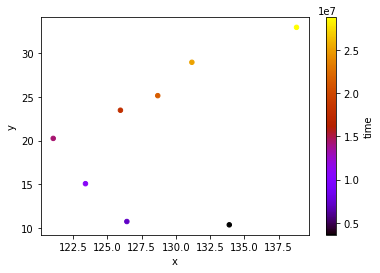

In [18]:
%matplotlib inline
floatout.loc[floatout.npart==47].plot.scatter('x','y',c='time',cmap='gnuplot',sharex=False)#.loc[floatout.npart==152]

In [91]:
import numpy as np
np.fromfile('/swot/SUM01/spencer/llc_floats/pickup_flt.0000000001.001.001.data','>f8').reshape(-1,9)

array([[ 3.00e+00, -1.00e+00,  0.00e+00,  0.00e+00, -1.00e+00,  3.00e+00,
         0.00e+00,  0.00e+00, -1.00e+00],
       [ 1.00e+00,  0.00e+00,  0.00e+00,  0.00e+00,  5.00e-01,  2.05e+01,
         8.64e+05,  9.00e+02, -1.00e+00],
       [ 2.00e+00,  0.00e+00,  0.00e+00,  0.00e+00,  5.00e-01,  2.05e+01,
         8.64e+05,  9.00e+02, -1.00e+00],
       [ 3.00e+00,  0.00e+00,  0.00e+00,  0.00e+00,  5.00e-01,  2.05e+01,
         8.64e+05,  9.00e+02, -1.00e+00]])

In [2]:
import numpy as np
check=np.fromfile('/home/spencerj/float_dhruv.bin','>f8').reshape(-1,9)
check[1]

array([ 1.00e+00,  0.00e+00,  2.50e+04,  2.50e+04, -5.00e-01,  2.05e+01,
        8.64e+05,  9.00e+02, -1.00e+00])

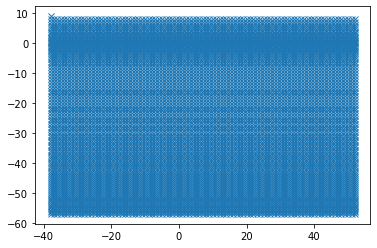

In [139]:
plt.plot(nodes[8281:8281+8100-1,0],nodes[8281:8281+8100-1,1],'x')


In [28]:
import pandas as pd
data = pd.read_csv("/swot/SUM01/spencer/test_csv/float_trajectories.0000000800.093.001.csv")
data=data.rename(columns = {list(data)[0]: 'dummy', list(data)[1]: 'npart',list(data)[2]: 'time',list(data)[3]: 'x',list(data)[4]: 'y',list(data)[5]: 'z',list(data)[6]: 't',list(data)[7]: 's',list(data)[8]: 'p'})
data.drop(['dummy'], axis=1)

,npart,time,x,y,z,t,s,p
0,104.0,2880000.0,-39.758236,-30.264131,-1834.68,3.076933,34.844832,0.319526
1,105.0,2880000.0,-59.510000,-10.023346,-1834.68,0.000000,0.000000,0.000000
2,106.0,2880000.0,-39.510000,-10.019439,-1834.68,0.000000,0.000000,0.000000


In [29]:
import numpy as np
names=list(np.arange(0,105))
prof = pd.read_csv("/swot/SUM01/spencer/test_csv/float_profiles.0000000720.093.001.csv",header=None,skip_blank_lines=False)
#prof=prof.rename(columns = {list(prof)[0]: 'dummy', list(prof)[1]: 'npart',list(prof)[2]: 'time',list(prof)[3]: 'x',list(prof)[4]: 'y',list(prof)[5]: 'z'})
#prof.drop(['dummy'], axis=1)

In [30]:
prof

,0,1,2,3,4,5,6,7,8,9,...,96,97,98,99,100,101,102,103,104,105
0,4636948397587169280,103.0,2592000.0,-59.510417,-30.075116,-5.0,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1,4637018766331346944,104.0,2592000.0,-39.749181,-30.276268,-5.0,23.959696,23.852547,23.480927,22.750618,...,34.92948,34.913464,34.878943,34.810755,27.728366,26.040717,0.0,0.0,0.0,0.0
2,4637089135075524608,105.0,2592000.0,-59.510000,-10.023346,-5.0,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
3,4637159503819702272,106.0,2592000.0,-39.510000,-10.019439,-5.0,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
